In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import pyqosc as qo
import scipy as sp

## **Mandelstam-Tamm Limit (No Dissipation)**

In [2]:
def ss_qsl(qosc, rho_0, timelst, plot = False, overlap_with = None):
    Ham, c_ops = qosc.dynamics()
    
    rho_ss = qt.steadystate(Ham, c_ops)
    
    rho_t = qt.mesolve(Ham, rho_0, timelst, c_ops).states
    
    l = len(timelst)
    dt = timelst[1]-timelst[0]
    mean_stdev_t = [np.nan]
    s = 0
    stdev0 = np.sqrt(qt.variance(Ham, rho_t[0]))
    for i in range(1,l):
        stdev = np.sqrt(qt.variance(Ham, rho_t[i]))
        mean_stdev_t.append((dt/(timelst[i]-timelst[0])) * (stdev0/2 + s + stdev/2))    # Usual trapz formula, divided by the total time
        s += stdev
    
    bures_angle_t = [qt.bures_angle(rho_t[i], rho_ss) for i in range(l)]
        
    qsl_t = [0]
    for i in range(1,l):
        qsl_t.append(bures_angle_t[i] / mean_stdev_t[i])
    
    if plot:
        if overlap_with:
            ax = overlap_with
        else:
            fig, ax = plt.subplots(1, figsize = (5, 4), constrained_layout = True)
            ax.set_ylabel(r"$\tau_\mathrm{QSL}$")
            ax.set_xlabel(r"$t$")
            ax.axvline(qosc.omega_0, ls = "--", c = "k", alpha = 0.4, label = r"$2\pi/\omega_0$")
            ax.legend(loc = "upper right")
        ax.plot(timelst[1:], qsl_t[1:])

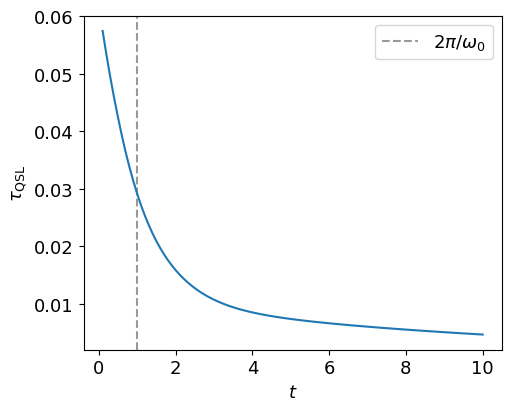

In [16]:
N = 50

vdp = qo.vdp(N, omega = 17, Omega = 1, gamma_1 = 1, gamma_2 = 0.1)

rho_0 = qt.coherent(N, 100)

timelst = np.linspace(0, 10, 101)

ss_qsl(vdp, rho_0, timelst, True)
plt.show()

## **Funo QSL (With Dissipation**)

In [78]:
def ss_qsl_funo(qosc, rho_0, init_tau = 1, fsolve_xtol = 1e-3, 
                fsolve_maxfev = int(1e6), mesolve_timepoints = 101, quad_limit = 101,
                mode = "iterative"):
    
    N = qosc.N
    Ham, c_ops = qosc.dynamics()
    rho_ss = qt.steadystate(Ham, c_ops)
    
    d_tr = ((rho_0-rho_ss).dag()*(rho_0-rho_ss)).sqrtm().tr() * 0.5
    
    def funo(tau):
        
        def rho(t):
            return qt.mesolve(Ham, rho_0, np.linspace(0, t, mesolve_timepoints), c_ops, options = qt.Options(nsteps=int(1e9))).states[-1]
                       
        def D(t):
            s = 0
            rho_t = rho(t)
            for c_op in c_ops:
                s += c_op * rho_t * c_op.dag() - 0.5 * qt.commutator(c_op.dag()*c_op, rho_t, kind = "anti")
            return s, rho_t
        
        def H_D(t):
            D_t, rho_t = D(t)
            rho_eigvals, rho_eigstates = rho_t.eigenstates()
            out = 0
            for m in range(N):
                pm = rho_eigvals[m]
                bm = rho_eigstates[m]
                for n in range(N):
                    pn = rho_eigvals[n]
                    if pn==pm:
                        continue
                    bn = rho_eigstates[n]
                    out += D_t.matrix_element(bm, bn) / (pn-pm) * bm * bn.dag()
            out *= 1j
            return out, rho_t
            
        def stdev_sum(t):
            H_D_t, rho_t = H_D(t)
            return np.sqrt(qt.variance(Ham, rho_t)) + np.sqrt(qt.variance(H_D_t, rho_t))
        
        #####
        
        def W(t):
            rho_t = rho(t)
            rho_eigvals, rho_eigstates = rho_t.eigenstates()
            
            Wmn = np.empty(shape=(len(c_ops),N,N))
            # Assuming [gamma] is independent of [omega], [W_{mn}^{omega,alpha}] and [W_{nm}^{-omega,alpha}]
            # are identical.
            
            for i in range(len(c_ops)):
                
                omega_is_0 = False
                if qt.commutator(c_ops[i],Ham)==0:
                    omega_is_0 = True
                
                for m in range(N):
                    bm = rho_eigstates[m]
                    
                    for n in range(N):
                        if m==n and omega_is_0:
                            Wmn[i][m][n] = 0
                        
                        bn = rho_eigstates[n]
                        
                        Wmn[i][m][n] = np.abs(bm.overlap(c_ops[i]*bn))**2
                        
            return rho_eigvals, Wmn
        
        def sigma_and_A(t):
            p, Wmn = W(t)
            sigma = 0
            A = 0
            for i in range(len(c_ops)):
                for m in range(N):
                    for n in range(N):
                        if not(p[m]==0 or p[n]==0):
                            sigma += Wmn[i][m][n] * p[n] * np.log(p[n]/p[m])
                        A += (p[n]+p[m]) * Wmn[i][m][n]
            return sigma, A
                
        #####
        
        def time_quad(func):
            return sp.integrate.quad(func, 0, tau, limit = quad_limit)[0]
        
        timelst = np.linspace(0, tau, quad_limit).flatten()
        sigma_lst = np.empty(shape=(quad_limit,))
        A_lst = np.empty(shape=(quad_limit,))
        sigma_lst[0] = 0
        A_lst[0] = 0
        for i in range(1, quad_limit):
            sigma_lst[i], A_lst[i] = sigma_and_A(float(timelst[i])) # Need to convert to float or qutip mesolve won't work.
        
        def time_trapz(x, y):
            return sp.integrate.trapz(y=y, x=x)
         
        return time_quad(stdev_sum) + np.sqrt(0.5 * time_trapz(timelst, sigma_lst) * time_trapz(timelst, A_lst)) - d_tr
        
    return sp.optimize.fsolve(funo, init_tau, xtol = fsolve_xtol, maxfev = fsolve_maxfev)[0]


In [79]:
N = 2
qosc = qo.vdp(N)
rho_0 = qt.basis(N,0) * qt.basis(N,0).dag()
ss_qsl_funo(qosc, rho_0, init_tau = 0.3)

The calculated quantum speed limit is 0.2630914247913295


0.2630914247913295

In [20]:
N = 2
qosc = qo.vdp(N)
rho_0 = qt.basis(N,0) * qt.basis(N,0).dag()
ss_qsl_funo(qosc, rho_0, init_tau = 3.0)

The calculated quantum speed limit is 0.2617324692234691


0.2617324692234691